<a href="https://colab.research.google.com/github/soyebganja/DL-Practice-Projects/blob/main/11%3AConvolutional%20Neural%20Networks%20(CNN)/11_7_Caltech101_Classification_Using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
import numpy as np
import torchvision

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Load Caltech101 Dataset

In [5]:
transform = transforms.Compose([
    transforms.Resize((128, 128)), # Resize images to a fixed size
    transforms.RandomHorizontalFlip(), # Randomly flip images horizontally
    transforms.RandomRotation(10), # Randomly rotate images by a small angle
    transforms.ToTensor(), # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [1]:
from google.colab import files
import os
import zipfile

# Create a folder to extract the files
!mkdir -p images

# Option 1: If your folder is already zipped
uploaded = files.upload()  # This will prompt you to select a zip file
zip_name = list(uploaded.keys())[0]

# Extract the zip file
with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall('images/')

print(f"Uploaded and extracted to 'images/' folder")

Saving Resources_TransferLearning_Caltech.zip to Resources_TransferLearning_Caltech.zip
Uploaded and extracted to 'images/' folder


In [6]:
dataset = datasets.ImageFolder(root='images/Download files/images', transform=transform)
len(dataset), dataset.classes

(9144,
 ['BACKGROUND_Google',
  'Faces',
  'Faces_easy',
  'Leopards',
  'Motorbikes',
  'accordion',
  'airplanes',
  'anchor',
  'ant',
  'barrel',
  'bass',
  'beaver',
  'binocular',
  'bonsai',
  'brain',
  'brontosaurus',
  'buddha',
  'butterfly',
  'camera',
  'cannon',
  'car_side',
  'ceiling_fan',
  'cellphone',
  'chair',
  'chandelier',
  'cougar_body',
  'cougar_face',
  'crab',
  'crayfish',
  'crocodile',
  'crocodile_head',
  'cup',
  'dalmatian',
  'dollar_bill',
  'dolphin',
  'dragonfly',
  'electric_guitar',
  'elephant',
  'emu',
  'euphonium',
  'ewer',
  'ferry',
  'flamingo',
  'flamingo_head',
  'garfield',
  'gerenuk',
  'gramophone',
  'grand_piano',
  'hawksbill',
  'headphone',
  'hedgehog',
  'helicopter',
  'ibis',
  'inline_skate',
  'joshua_tree',
  'kangaroo',
  'ketch',
  'lamp',
  'laptop',
  'llama',
  'lobster',
  'lotus',
  'mandolin',
  'mayfly',
  'menorah',
  'metronome',
  'minaret',
  'nautilus',
  'octopus',
  'okapi',
  'pagoda',
  'panda'

In [7]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

len(train_dataset), len(test_dataset)

(7315, 1829)

In [8]:
# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
for i, (images, labels) in enumerate(train_loader):
  print(images.shape)
  print(labels.shape)
  break

torch.Size([32, 3, 128, 128])
torch.Size([32])


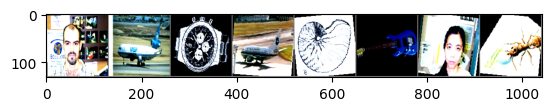

In [10]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# Show Images
imshow(torchvision.utils.make_grid(images[:8]))

In [11]:
labels[:8]

tensor([ 1,  6, 95,  6, 67, 36,  1,  8])

In [12]:
[ dataset.classes[i] for i in labels[:8] ]

['Faces',
 'airplanes',
 'watch',
 'airplanes',
 'nautilus',
 'electric_guitar',
 'Faces',
 'ant']

In [17]:
class ConvNet(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.network = nn.Sequential(

      nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), padding="same"), # output (32, 128, 128)
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)), # output (32, 16, 16)

      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding="same"), # output (64, 64, 64)
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)), # output (64, 7, 7)

      nn.Flatten(),
      nn.Linear(64 * 32 * 32, 256),  # Use calculated size
      nn.ReLU(),
      nn.Linear(256, 128),
      nn.ReLU(),
      nn.Linear(128, num_classes)
    )

  def forward(self, x):
    return self.network(x)

In [36]:
# Traininig Loop
def train_model(model, train_loader, num_epochs, optimizer, criterian):
  total_step = len(train_loader)
  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)

      # Forward pass
      outputs = model(images)
      loss = criterian(outputs, labels)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    if (i+1) % 100 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {running_loss/len(train_loader):.4f}')


In [19]:
num_classes = len(dataset.classes)
learning_rate = 0.001
num_epochs = 2

model = ConvNet(num_classes).to(device)
criterian = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_model(model, train_loader, num_epochs, optimizer, criterian)

In [30]:
def test_model(model, test_loader, device):
    """
    Evaluate the model on the test set and print accuracy

    Args:
        model: the trained model to evaluate
        test_loader: DataLoader for the test dataset
        device: device to run the model on (cuda or cpu)
    """
    # Set model to evaluation mode
    model.eval()
    correct = 0
    total = 0

    # No gradient calculation needed for testing
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Get predictions
            _, predicted = torch.max(outputs.data, 1)

            # Calculate accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print final accuracy
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    return accuracy

In [31]:
# Example usage:
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Assuming your model and test_loader are defined
    # model = ...
    # test_loader = ...

    # First train the model (code from previous examples)
    # train_model(model, train_loader, num_epochs, optimizer, criterion)

    # Then test the model
    test_model(model, test_loader, device)

if __name__ == "__main__":
    main()

Test Accuracy: 42.04%


### Trying with ResNet pre trained model

In [ ]:
# learning_rate = 0.001

model = ConvNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_model(model, train_loader, num_epochs, optimizer, criterian)

In [6]:
from torchvision import models

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

NameError: name 'num_classes' is not defined